In [1]:
import warnings
# 忽略警告訊息
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

df = pd.read_csv('loan_train.csv')
df.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [2]:
df.shape

(614, 13)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
df['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

<AxesSubplot:xlabel='count', ylabel='Gender'>

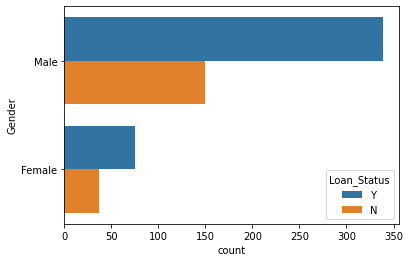

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(y='Gender', hue='Loan_Status', data=df)

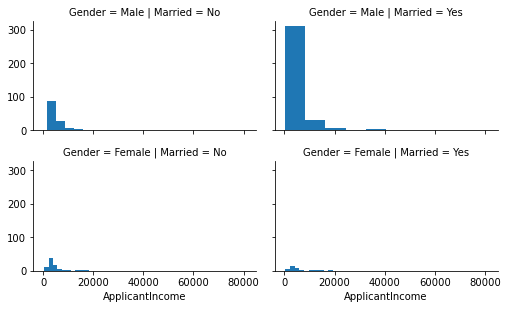

In [6]:
grid = sns.FacetGrid(df, row='Gender', col='Married', 
                     size=2.2, aspect=1.6)
grid.map(plt.hist, 'ApplicantIncome', bins=10)
grid.add_legend()

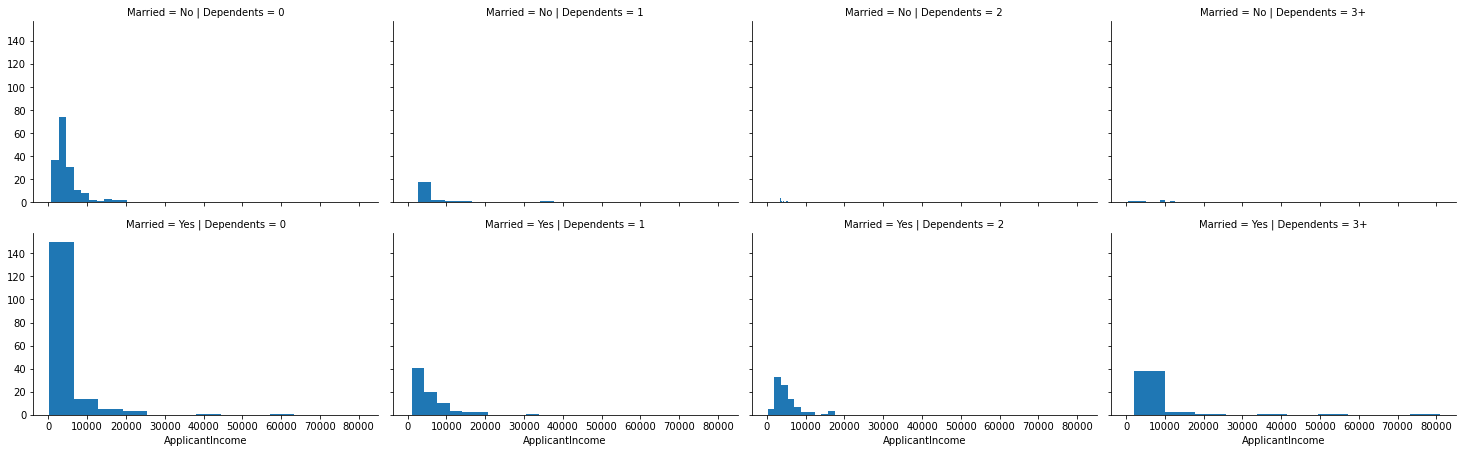

In [7]:
grid = sns.FacetGrid(df, row='Married', col='Dependents', 
                     size=3.2, aspect=1.6)
grid.map(plt.hist, 'ApplicantIncome', bins=10)
grid.add_legend()

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=0)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), 
                                      ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [10]:
from sklearn.compose import ColumnTransformer

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).drop(['Loan_Status'], axis=1).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

classifiers = [KNeighborsClassifier(3), 
               SVC(kernel="rbf", C=0.025, probability=True), 
               RandomForestClassifier(max_depth=5)]

for clf in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf)])
    pipe.fit(X_train, y_train)   
    print(clf)
    print("Testing score: %.3f" % pipe.score(X_test, y_test))

KNeighborsClassifier(n_neighbors=3)
Testing score: 0.756
SVC(C=0.025, probability=True)
Testing score: 0.732
RandomForestClassifier(max_depth=5)
Testing score: 0.732


In [ ]:
from sklearn.model_selection import GridSearchCV

rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])
param_grid = { 
    'classifier__n_estimators': range(20, 200, 20),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [4,5,6,7,8]}

grid_s = GridSearchCV(rf, param_grid, n_jobs=-1)
                  
grid_s.fit(X_train, y_train) 
print('Best score (training):', grid_s.best_score_)
print(grid_s.best_params_)
print(grid_s.score(X_test, y_test))